In [22]:
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy
import cv2
import scipy
from skimage.feature import peak_local_max
from torchvision import transforms
import pickle
from torchdiffeq import odeint_adjoint as odeint
from scipy.integrate import solve_ivp
device = torch.device('cpu')

In [3]:
def diffeq(t, x):
    x0 = torch.tensor(x).clone().detach()

    x1 = x0.clone().detach()
    x1.requires_grad = True
    f1 = F1(x1,p)
    f1.backward()
    grad1 = x1.grad

    x2 = x0.clone().detach()
    x2 = x2 + torch.tensor([2,1])
    x2.requires_grad = True
    f2 = F2(x2,p)
    f2.backward()
    grad2 = x2.grad 

    dudt = grad1[0] 
    dvdt = grad1[1] 
    # dudt = -1*(1-Chi(x0))*p[4]*grad1[0] - Chi(x0)*p[5]*grad2[0]
    # dvdt = -1*(1-Chi(x0))*p[4]*grad1[1] - Chi(x0)*p[5]*grad2[1]

    if isinstance(dudt, torch.Tensor):
        A = [dudt.numpy(), dvdt.numpy()]
    else:
        A = [dudt, dvdt]
    return A

def F1(x, p):
    u = x[0]
    v = x[1]
    f = u**4 + v**4 + v**3 - 4*u**2*v + v**2 + p[0]*u + p[1]*v
    return f

def F2(x, p):
    u = x[0]
    v = x[1]
    f = u**4 + v**4 - u**3 + 2*v**2*u - u**2 - p[2]*u + p[3]*v
    return f

def Chi(x):
    res = (np.tanh(10*(x[0]-0.5))+1)/2
    # reduce the factor to the gluing function
    return res

In [4]:
def index_map(h):
    f_1 = h[:,:,0]
    f_2 = h[:,:,1]
    norm = 1/(f_1**2 + f_2**2)

    G_x = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    G_y = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
    grad_f_1 = scipy.signal.convolve2d(f_1, G_x, mode="same") + scipy.signal.convolve2d(f_1, G_y, mode="same")
    grad_f_2 = scipy.signal.convolve2d(f_2, G_x, mode="same") + scipy.signal.convolve2d(f_2, G_y, mode="same")
    index = norm*(f_1*grad_f_2 - f_2*grad_f_1)
    return index

def return_crit_point(indexmap):
    ind_peak = peak_local_max(indexmap, min_distance=2)
    ind_nan = np.argwhere(np.isnan(indexmap))
    ind_crit_point = np.concatenate((ind_peak, ind_nan), axis = 0)
    return ind_crit_point

def crit_point_stability(critpoint, h, fun_grad = None):
    if fun_grad is not None:
        f_1x, f_1y, f_2x, f_2y = fun_grad
    else:
        f_1 = h[:,:,0]
        f_2 = h[:,:,1]

        G_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        G_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        f_1x, f_1y = scipy.signal.convolve2d(f_1, G_x, mode="same"), scipy.signal.convolve2d(f_1, G_y, mode="same")
        f_2x, f_2y = scipy.signal.convolve2d(f_2, G_x, mode="same"), scipy.signal.convolve2d(f_2, G_y, mode="same")

    x = critpoint[0]
    y = critpoint[1]
    A = np.array([[f_1x[x,y], f_1y[x,y]], [f_2x[x,y], f_2y[x,y]]])
    eigval = scipy.linalg.eig(A)[0]
    return np.real(eigval)

def index_to_coord(index_x, index_y, coord):
    x = coord[index_x, index_y, 0]
    y = coord[index_x, index_y, 1] 
    return x, y


In [5]:
%run Supporting_Function.py
%run ODE_Func.py
%run Ploting_Function.py

In [6]:
p = [0.5 for i in range(6)]
p[0] = 0.1
p[1] = 0.5

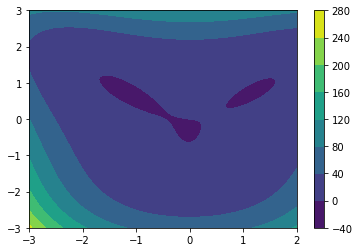

In [7]:
plt.figure()
size = 100
X = np.linspace(-3, 2, size)
Y = np.linspace(-3, 3, size)
coord = np.array(np.meshgrid(X, Y))
F1_sample = F1(coord, p)
plt.contourf(coord[0],coord[1], F1_sample)
plt.colorbar()
plt.show()

In [8]:
size = 400
X = np.linspace(-3, 2, size)
Y = np.linspace(-3, 3, size)
x, y = np.array(np.meshgrid(X, Y))
coord_flat_4nn = torch.tensor(np.stack([x, y], -1).reshape(size * size, 2)).detach().numpy()
flow = np.zeros((size**2, 2))

for i in range(size**2):
    flow[i,:] = diffeq(0,  coord_flat_4nn[i])

coord_mesh = coord_flat_4nn.reshape(size, size, 2)
x_coord_mesh = coord_mesh[:,:, 0]
y_coord_mesh = coord_mesh[:,:, 1]

flow_mesh = flow.reshape(size, size, 2)
flow_torch = torch.from_numpy(flow)

F1_mesh = F1([x,y], p)
F1_sample = F1_mesh.reshape(-1, 1)
F1_torch = torch.from_numpy(F1_sample)

In [9]:
X = np.linspace(-3, 2, size)
Y = np.linspace(-3, 3, size)
x, y = np.array(np.meshgrid(X, Y))

In [10]:
def gaussian(coord, x0 = 0, y0 = 0, sigma= 0.01):
  x = coord[0] - x0
  y = coord[1] - y0
  z = (1/(2*np.pi*sigma*sigma) * np.exp(-(x**2/(2*sigma**2)
     + y**2/(2*sigma**2))))
  return z

In [11]:
index = index_map(flow_mesh)
index_crit_point = return_crit_point(index)

stable = []
unstable = []
rest = []
for i in range(np.shape(index_crit_point)[0]):
    temp_crit_point = index_crit_point[i]
    eigval = crit_point_stability(temp_crit_point , flow_mesh)
    
    if np.prod(eigval)>0 and eigval[0]>0 :
        stable.append(temp_crit_point)
    elif np.prod(eigval)>0 and eigval[0]<0 :
        unstable.append(temp_crit_point)
    else: 
        print(eigval)
        print(temp_crit_point)
        rest.append(temp_crit_point)

stable = np.array(stable)
unstable = np.array(unstable)
rest = np.array(rest)

[ 0.13331565 -0.54770027]
[202 209]
[ 0.16231018 -0.66947844]
[208 276]


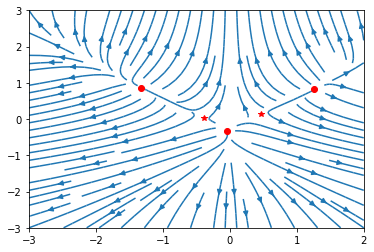

In [12]:
plt.figure()
if np.shape(stable)[0] != 0:
    x_temp, y_temp = index_to_coord(stable[:, 0], stable[:, 1], coord_mesh)
    plt.plot(x_temp, y_temp, 'r.')

if np.shape(unstable)[0] != 0:
    x_temp, y_temp = index_to_coord(unstable[:, 0], unstable[:, 1], coord_mesh)
    plt.plot(x_temp, y_temp, 'ro')

if np.shape(rest)[0] != 0:
    x_temp, y_temp = index_to_coord(rest[:, 0], rest[:, 1], coord_mesh)
    plt.plot(x_temp, y_temp, 'r*')
plt.streamplot(coord_mesh[:,:,0], coord_mesh[:,:,1], flow_mesh[:,:,0], flow_mesh[:,:,1])
plt.show()

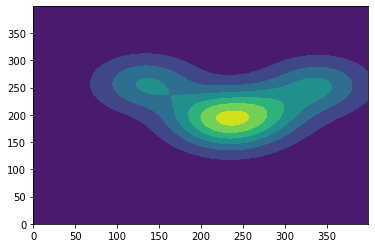

In [13]:
weight_map = np.ones([size, size])
if np.shape(stable)[0] != 0:
    x_temp, y_temp = index_to_coord(stable[:, 0], stable[:, 1], coord_mesh)

for i in range(len(x_temp)):
    weight_map = weight_map + gaussian([x_coord_mesh, y_coord_mesh], x0 = x_temp[i], y0 = y_temp[i], sigma= 0.5)

if np.shape(unstable)[0] != 0:
    x_temp, y_temp = index_to_coord(unstable[:, 0], unstable[:, 1], coord_mesh)

for i in range(len(x_temp)):
    weight_map = weight_map + gaussian([x_coord_mesh, y_coord_mesh], x0 = x_temp[i], y0 = y_temp[i], sigma= 0.5)

normalization = size*size/np.sum(weight_map)
weight_map = weight_map * normalization
weight_map_torch = torch.from_numpy(weight_map.reshape(-1, 1))

plt.figure()
plt.contourf(weight_map)
plt.show()

In [14]:
size = 400

In [39]:
class GaussianFunc_full(nn.Module):

  def __init__(self, dim = 2, nhidden_M=8, nhidden_P = 8, n_V = 2, nlayer_M = 1):
    super(GaussianFunc_full, self).__init__()

    self.n_V = n_V
    self.ndim = dim
    self.potential_list = nn.ModuleList([])

    self.th = nn.Tanh() 
    self.sg = nn.Sigmoid()
    self.softplus = nn.Softplus(100)
    self.elu = nn.ELU(inplace = True)
    self.relu = nn.ReLU(inplace = True)

    self.metric_list = nn.ModuleList([nn.Linear(dim, nhidden_M)])

    for i in range(nlayer_M):
      self.metric_list.append(nn.Linear(nhidden_M, nhidden_M))
    self.metric_list.append(nn.Linear(nhidden_M, 2))

    for i in range(n_V):
      self.potential_list.append(nn.Linear(dim, nhidden_P))
      self.potential_list.append(nn.Linear(nhidden_P, nhidden_P, bias = False))
      self.potential_list.append(nn.Linear(nhidden_P, 1, bias = False))

  def softSig(self, input):
    Amp = 0.3
    slope = 2
    output = 1 + torch.log(slope*self.softplus(input) + 1) + torch.tanh(-1*slope*self.softplus(-1*input))
    output = Amp*output
    return output

  def metric(self, x):
    out = self.metric_list[0](x)
    out = self.softplus(out)
    
    for i, nlayer in enumerate(self.metric_list[1:-1]):
      out = nlayer(out)
      out = self.softplus(out)
    
    out = self.metric_list[-1](out)
    out = self.softSig(out)
    return out

  def potential(self, num, x, return_all= False):
    size = 3
    start = size*num
    end = size*(num+1)
    layers_V = self.potential_list[start:end]
    self.last_layers = layers_V

    out = layers_V[0](x)
    out = torch.pow(out, 2)
    out1 = out

    out = layers_V[1](out)
    out = torch.exp(out)
    out2 = out

    out = layers_V[-1](out)
    out3 = out

    if return_all:
      return out1, out2, out3 
    else:
      return out3

  def gradient(self, num, x):
    f1,f2,f3 = self.potential(num, x, True)
    layers_V = self.last_layers

    W3 = layers_V[-1].weight.data
    grad = W3

    W2 = layers_V[1].weight.data
    f2_prime = f2
    grad = torch.mm(grad*f2_prime, W2)

    W1 = layers_V[0].weight.data
    f1_prime = 2*layers_V[0](x)
    grad = torch.mm(grad*f1_prime, W1)
    return grad

  def total_grad(self, x):
    grad = self.gradient(0, x)
    for i in range(1,self.n_V):
      grad = grad + self.gradient(i, x)
    grad = grad/self.n_V
    return grad

  def total_V(self,x):
    out = self.potential(0,x)
    for i in range(1,self.n_V):
      out = out + self.potential(i,x)
    out = out/self.n_V
    return out

  def forward(self, x):
    grad = self.total_grad(x)
    metric = self.metric(x)
    out = metric*grad
    return out

In [40]:
func = GaussianFunc_full(2, 64, 3, 16)
params = list(func.parameters())

lr = 0.01
optimizer = optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()
pred_steps = 500
min_loss = np.inf

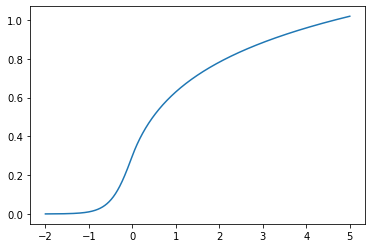

In [38]:
plt.figure()
data = func.softSig(torch.Tensor(np.linspace(-2, 5, 1000))).detach().numpy()
plt.plot(np.linspace(-2, 5, 1000), data)
plt.show()

In [20]:
A, B = torch.Tensor(np.stack([x, y], -1).reshape(size * size, 2)).split(1,1)

In [21]:
A.shape

torch.Size([160000, 1])

In [41]:
try:
    for itr in range(1, 10**6):
        optimizer.zero_grad()
        pred = func(torch.Tensor(np.stack([x, y], -1).reshape(size * size, 2))) 
        # scaling_const =  torch.mean(flow_torch / pred)
        loss = (weight_map_torch*torch.abs(pred - flow_torch)).sum()/pred.shape[0]
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())

        display.clear_output()
        print('Iter: {}, MSE loss: {:.4f}'.format(itr, -loss_meter.avg))

        if loss_meter.avg <= min_loss:
          torch.save(func, 'min_func_gaussian.pt')
          min_loss = loss_meter.avg
          print("min model_updated")


except KeyboardInterrupt:
    print('Training complete after {} iters.'.format(itr))

Iter: 21669, MSE loss: -1.2243
Training complete after 21670 iters.


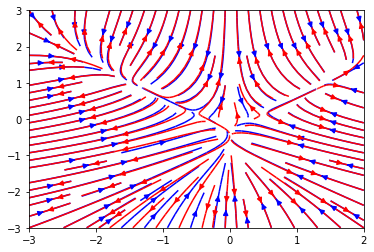

In [43]:
dXdt = min_func(torch.Tensor(np.stack([x, y], -1).reshape(size*size, 2))).detach().numpy()
dXdt = dXdt.reshape(size,size,2)

dXdt2 = flow_torch.reshape(size,size,2).detach().numpy()

plt.figure()
plt.streamplot(coord_mesh[:,:,0], coord_mesh[:,:,1], -dXdt2[:,:,0], -dXdt2[:,:,1], color = 'b')
plt.streamplot(coord_mesh[:,:,0], coord_mesh[:,:,1], dXdt[:,:,0], dXdt[:,:,1], color = 'r')
plt.show()

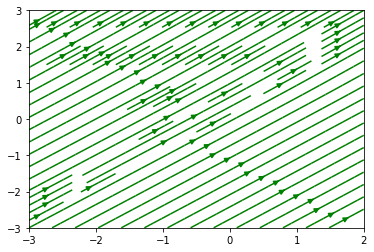

In [46]:
dXdt = min_func.metric(torch.Tensor(np.stack([x, y], -1).reshape(size*size, 2))).detach().numpy()
dXdt = dXdt.reshape(size,size,2)

dXdt2 = flow_torch.reshape(size,size,2).detach().numpy()

plt.figure()
# plt.streamplot(coord_mesh[:,:,0], coord_mesh[:,:,1], -dXdt2[:,:,0], -dXdt2[:,:,1], color = 'b')
plt.streamplot(coord_mesh[:,:,0], coord_mesh[:,:,1], dXdt[:,:,0], dXdt[:,:,1], color = 'g')
plt.show()

In [48]:
min_func.metric(torch.Tensor(np.stack([x, y], -1).reshape(size*size, 2)))

tensor([[3.5152, 3.4370],
        [3.5146, 3.4365],
        [3.5141, 3.4359],
        ...,
        [3.5162, 3.6430],
        [3.5163, 3.6432],
        [3.5164, 3.6434]], grad_fn=<MulBackward0>)

In [49]:
min_func = torch.load('min_func_gaussian_Hamiltonian_noMetric.pt')

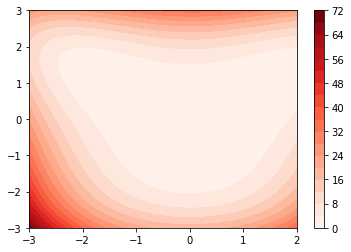

In [45]:
plt.figure()
temp_x, temp_y = np.meshgrid(np.linspace(-3, 2, size), np.linspace(-3, 3, size))
h = min_func.total_V(torch.Tensor(np.stack([temp_x, temp_y], -1).reshape(size * size, 2))).reshape(size, size).detach().numpy()
plt.contourf(temp_x, temp_y, h, 20 , cmap='Reds')
plt.colorbar()
plt.show()